# Get Data

In [1]:
import os

if not os.path.exists("./datasets"):
  !mkdir -p "/content/datasets/Annotations"
  !mkdir -p "/content/datasets/Questions"
  !mkdir -p "/content/datasets/Images/test"
  !mkdir -p "/content/datasets/Images/train"
  !mkdir -p "/content/datasets/Images/val"

  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Train_abstract_v002.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Val_abstract_v002.zip
  !unzip Annotations_Train_abstract_v002.zip -d ./datasets/Annotations
  !unzip Annotations_Val_abstract_v002.zip -d ./datasets/Annotations

  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Train_abstract_v002.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Val_abstract_v002.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Test_abstract_v002.zip
  !unzip Questions_Train_abstract_v002.zip -d ./datasets/Questions
  !unzip Questions_Val_abstract_v002.zip -d ./datasets/Questions
  !unzip Questions_Test_abstract_v002.zip -d ./datasets/Questions

  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_train2015.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_val2015.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_test2015.zip
  !unzip scene_img_abstract_v002_train2015.zip -d ./datasets/Images/train
  !unzip scene_img_abstract_v002_val2015.zip -d ./datasets/Images/val
  !unzip scene_img_abstract_v002_test2015.zip -d ./datasets/Images/test

# Preprocess Data

In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm

!pip install vit-pytorch

if not os.path.exists("./data_loader.py"):
  !wget https://raw.githubusercontent.com/stran123/basic_vqa/master/data_loader.py

if not os.path.exists("./models.py"):
  !wget https://raw.githubusercontent.com/stran123/basic_vqa/master/models.py

if not os.path.exists("./utils"):
  !mkdir -p "/content/utils"
  !wget https://raw.githubusercontent.com/stran123/basic_vqa/master/utils/text_helper.py -O ./utils/text_helper.py
  !wget https://raw.githubusercontent.com/stran123/basic_vqa/master/utils/resize_images.py -O ./utils/resize_images.py
  !wget https://raw.githubusercontent.com/stran123/basic_vqa/master/utils/make_vacabs_for_questions_answers.py -O ./utils/make_vacabs_for_questions_answers.py
  !wget https://raw.githubusercontent.com/stran123/basic_vqa/master/utils/build_vqa_inputs.py -O ./utils/build_vqa_inputs.py

from data_loader import get_loader
from models import VqaModel

--2021-05-08 10:47:03--  https://raw.githubusercontent.com/stran123/basic_vqa/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8183 (8.0K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   7.99K  --.-KB/s    in 0s      

2021-05-08 10:47:03 (86.2 MB/s) - ‘models.py’ saved [8183/8183]



In [4]:
os.chdir("./utils")
if not os.path.exists("../datasets/Resized_Images"):
  !python resize_images.py --input_dir='../datasets/Images' --output_dir='../datasets/Resized_Images'  
  !python make_vacabs_for_questions_answers.py --input_dir='../datasets'
  !python build_vqa_inputs.py --input_dir='../datasets' --output_dir='../datasets'
os.chdir("../datasets/Resized_Images")
if os.path.exists("./test") and not os.path.exists("./test2015"):
  !mv test test2015
if os.path.exists("./train") and not os.path.exists("./train2015"):
  !mv train train2015
if os.path.exists("./val") and not os.path.exists("./val2015"):
  !mv val val2015
os.chdir("../..")
!rm -rf *.zip

[1000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[2000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[3000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[4000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[5000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[6000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[7000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[8000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[9000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[10000/10000] Resized the images and saved into '../datasets/Resized_Images/val'.
[1000/20000] Resized the images and saved into '../datasets/Resized_Images/train'.
[2000/20000] Resized the images and saved into '../datasets/Resized_Images/train'.
[3000/20000] Resized th

# Model arguments

In [3]:
class Args:
  def __init__(self, input_dir = './datasets', output_dir = './output',
               max_qst_length = 30, max_num_ans = 10,
               embed_size = 1024, word_embed_size = 300,
               num_layers = 2, hidden_size = 512,
               learning_rate = 1e-3, step_size = 10, gamma = 0.1,
               num_epochs = 30, batch_size = 128,
               num_workers = 4, save_step = 1,
               use_transformer = False, use_vit = False, patch_size=28):
    self.input_dir = input_dir
    self.output_dir = output_dir
    self.max_qst_length = max_qst_length
    self.max_num_ans = max_num_ans
    self.embed_size = embed_size
    self.word_embed_size = word_embed_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    self.step_size = step_size
    self.gamma = gamma
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.save_step = save_step
    self.use_transformer = use_transformer
    self.use_vit = use_vit
    self.patch_size = patch_size

In [19]:
args = Args(output_dir='vit', num_epochs=30, use_vit=True, patch_size=28)

# Make model

In [20]:
data_loader = get_loader(
        input_dir=args.input_dir,
        input_vqa_train='train.npy',
        input_vqa_valid='valid.npy',
        max_qst_length=args.max_qst_length,
        max_num_ans=args.max_num_ans,
        batch_size=args.batch_size,
        num_workers=args.num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qst_vocab = data_loader['train'].dataset.qst_vocab
ans_vocab = data_loader['train'].dataset.ans_vocab

qst_vocab_size = qst_vocab.vocab_size
ans_vocab_size = ans_vocab.vocab_size
ans_unk_idx = data_loader['train'].dataset.ans_vocab.unk2idx

model = VqaModel(
        embed_size=args.embed_size,
        qst_vocab_size=qst_vocab_size,
        ans_vocab_size=ans_vocab_size,
        word_embed_size=args.word_embed_size,
        num_layers=args.num_layers,
        hidden_size=args.hidden_size,
        use_transformer=args.use_transformer,
        use_vit=args.use_vit,
        patch_size=args.patch_size).to(device)

Using ViT


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Train a model

In [21]:
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.output_dir+'/logs', exist_ok=True)
os.makedirs(args.output_dir+'/models', exist_ok=True)

criterion = nn.CrossEntropyLoss()

# params = list(model.img_encoder.fc.parameters()) \
#     + list(model.qst_encoder.parameters()) \
#     + list(model.fc1.parameters()) \
#     + list(model.fc2.parameters())
params = model.parameters() # for ViT

optimizer = optim.Adam(params, lr=args.learning_rate)
scheduler = lr_scheduler.StepLR(
    optimizer, step_size=args.step_size, gamma=args.gamma)

In [ ]:
for epoch in tqdm(range(args.num_epochs)):

    for phase in ['train', 'valid']:

        running_loss = 0.0
        running_corr_exp1 = 0
        running_corr_exp2 = 0
        batch_step_size = len(data_loader[phase].dataset) / args.batch_size

        if phase == 'train':
            scheduler.step()
            model.train()
        else:
            model.eval()
        batch_idx = 0
        for batch_sample in tqdm(data_loader[phase]):
            image = batch_sample['image'].to(device)
            question = batch_sample['question'].to(device)
            label = batch_sample['answer_label'].to(device)
            # not tensor, list.
            multi_choice = batch_sample['answer_multi_choice']

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):

                # [batch_size, ans_vocab_size=1000]
                output = model(image, question)
                _, pred_exp1 = torch.max(output, 1)  # [batch_size]
                _, pred_exp2 = torch.max(output, 1)  # [batch_size]
                loss = criterion(output, label)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Evaluation metric of 'multiple choice'
            # Exp1: our model prediction to '<unk>' IS accepted as the answer.
            # Exp2: our model prediction to '<unk>' is NOT accepted as the answer.
            pred_exp2[pred_exp2 == ans_unk_idx] = -9999
            running_loss += loss.item()
            running_corr_exp1 += torch.stack([(ans == pred_exp1.cpu())
                                              for ans in multi_choice]).any(dim=0).sum()
            running_corr_exp2 += torch.stack([(ans == pred_exp2.cpu())
                                              for ans in multi_choice]).any(dim=0).sum()

            # Print the average loss in a mini-batch.
            if batch_idx % 100 == 0:
                print('| {} SET | Epoch [{:02d}/{:02d}], Step [{:04d}/{:04d}], Loss: {:.4f}'
                      .format(phase.upper(), epoch+1, args.num_epochs, batch_idx, int(batch_step_size), loss.item()))
            batch_idx += 1
            
        # Print the average loss and accuracy in an epoch.
        epoch_loss = running_loss / batch_step_size
        epoch_acc_exp1 = running_corr_exp1.double(
        ) / len(data_loader[phase].dataset)      # multiple choice
        epoch_acc_exp2 = running_corr_exp2.double(
        ) / len(data_loader[phase].dataset)      # multiple choice

        print('| {} SET | Epoch [{:02d}/{:02d}], Loss: {:.4f}, Acc(Exp1): {:.4f}, Acc(Exp2): {:.4f} \n'
              .format(phase.upper(), epoch+1, args.num_epochs, epoch_loss, epoch_acc_exp1, epoch_acc_exp2))

        # Log the loss and accuracy in an epoch.
        with open(os.path.join(args.output_dir, 'logs/{}-log-epoch-{:02}.txt')
                  .format(phase, epoch+1), 'w') as f:
            f.write(str(epoch+1) + '\t'
                    + str(epoch_loss) + '\t'
                    + str(epoch_acc_exp1.item()) + '\t'
                    + str(epoch_acc_exp2.item()))

    # Save the model check points.
    if (epoch+1) % args.save_step == 0:
        torch.save({'epoch': epoch+1, 'state_dict': model.state_dict()},
                    os.path.join(args.output_dir, 'models/model-epoch-{:02d}.ckpt'.format(epoch+1)))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


| TRAIN SET | Epoch [01/30], Step [0000/0468], Loss: 6.9200
| TRAIN SET | Epoch [01/30], Step [0100/0468], Loss: 3.9977
| TRAIN SET | Epoch [01/30], Step [0200/0468], Loss: 3.0889
| TRAIN SET | Epoch [01/30], Step [0300/0468], Loss: 2.8654
| TRAIN SET | Epoch [01/30], Step [0400/0468], Loss: 2.5495

| TRAIN SET | Epoch [01/30], Loss: 3.4700, Acc(Exp1): 0.3592, Acc(Exp2): 0.3592 



| VALID SET | Epoch [01/30], Step [0000/0234], Loss: 2.7768
| VALID SET | Epoch [01/30], Step [0100/0234], Loss: 2.7216
| VALID SET | Epoch [01/30], Step [0200/0234], Loss: 2.8747

| VALID SET | Epoch [01/30], Loss: 2.7795, Acc(Exp1): 0.4335, Acc(Exp2): 0.4335 



| TRAIN SET | Epoch [02/30], Step [0000/0468], Loss: 2.9071
| TRAIN SET | Epoch [02/30], Step [0100/0468], Loss: 2.8294
| TRAIN SET | Epoch [02/30], Step [0200/0468], Loss: 3.0371
| TRAIN SET | Epoch [02/30], Step [0300/0468], Loss: 2.4123
| TRAIN SET | Epoch [02/30], Step [0400/0468], Loss: 2.6513

| TRAIN SET | Epoch [02/30], Loss: 2.7809, Acc(Exp1): 0.4143, Acc(Exp2): 0.4134 



| VALID SET | Epoch [02/30], Step [0000/0234], Loss: 2.9043
| VALID SET | Epoch [02/30], Step [0100/0234], Loss: 3.0437
| VALID SET | Epoch [02/30], Step [0200/0234], Loss: 2.5866

| VALID SET | Epoch [02/30], Loss: 2.6075, Acc(Exp1): 0.4444, Acc(Exp2): 0.4433 



| TRAIN SET | Epoch [03/30], Step [0000/0468], Loss: 2.7402
| TRAIN SET | Epoch [03/30], Step [0100/0468], Loss: 2.8543
| TRAIN SET | Epoch [03/30], Step [0200/0468], Loss: 2.6105
| TRAIN SET | Epoch [03/30], Step [0300/0468], Loss: 2.3275
| TRAIN SET | Epoch [03/30], Step [0400/0468], Loss: 2.7773

| TRAIN SET | Epoch [03/30], Loss: 2.6019, Acc(Exp1): 0.4437, Acc(Exp2): 0.4419 



| VALID SET | Epoch [03/30], Step [0000/0234], Loss: 2.7579
| VALID SET | Epoch [03/30], Step [0100/0234], Loss: 2.4423
| VALID SET | Epoch [03/30], Step [0200/0234], Loss: 2.3432

| VALID SET | Epoch [03/30], Loss: 2.4668, Acc(Exp1): 0.4833, Acc(Exp2): 0.4818 



| TRAIN SET | Epoch [04/30], Step [0000/0468], Loss: 2.4918
| TRAIN SET | Epoch [04/30], Step [0100/0468], Loss: 2.8394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


FileNotFoundError: ignored

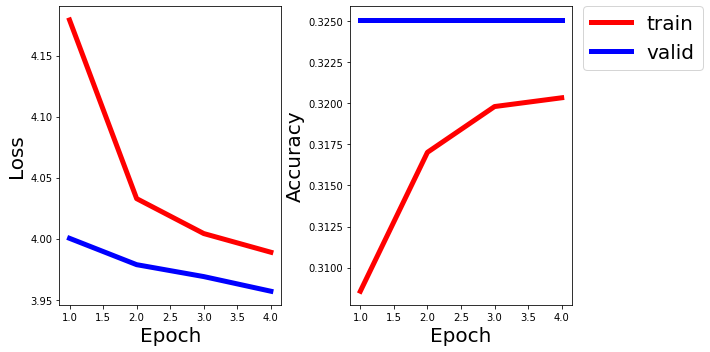

In [18]:
import numpy as np
import csv
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))

for phase in ['train', 'valid']:
    
    epoch = []
    loss = []
    acc = []
    
    for i in range(args.num_epochs):
        
        with open(f'./{args.output_dir}/logs/{phase}-log-epoch-{i+1:02d}.txt', 'r') as f:
            df = csv.reader(f, delimiter='\t')
            data = list(df)

        epoch.append(float(data[0][0]))
        loss.append(float(data[0][1]))
        acc.append(float(data[0][3]))

    plt.subplot(1, 2, 1)
    if phase == 'train':
        plt.plot(epoch, loss, label = phase, color = 'red', linewidth = 5.0)
    else:
        plt.plot(epoch, loss, label = phase, color = 'blue', linewidth = 5.0)
            
    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
        
    plt.subplot(1, 2, 2)
    plt.tight_layout()

    if phase == 'train':
        plt.plot(epoch, acc, label = phase, color = 'red', linewidth = 5.0)
    else:
        plt.plot(epoch, acc, label = phase, color = 'blue', linewidth = 5.0)
    
    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})
    
    
plt.savefig(f'./{args.output_dir}/png/train.png', dpi = fig.dpi)

# Test a model




## Load some weights

In [ ]:
!git clone https://github.com/stran123/6.869-final-project-lfs

Cloning into '6.869-final-project-lfs'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [ ]:
model_path = 'original-model-30.ckpt'
model.load_state_dict(torch.load(model_path)['state_dict'])

<All keys matched successfully>

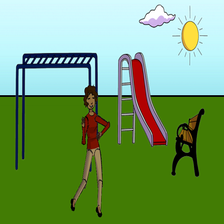

In [ ]:
from PIL import Image
image_path = './datasets/Resized_Images/'
img = Image.open(image_path+"train2015/abstract_v002_train2015_000000000000.png")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for batch_sample in tqdm(data_loader[phase]):
    image = batch_sample['image'].to(device)
    question = batch_sample['question'].to(device)
    break

image = image[0].unsqueeze(0)
question = question[0].unsqueeze(0)

displayable_img = image.cpu()[0].permute(1,2,0).numpy()*3

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import spacy
tokenizer = spacy.load('en_core_web_sm')

max_qst_length = 30

user_question = input("Ask a question about this image:\n")

parsed_user_question = [token.text for token in tokenizer(user_question.lower())]

question = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
question[:len(parsed_user_question)] = [qst_vocab.word2idx(w) for w in parsed_user_question]
question = torch.tensor(question).unsqueeze(0).to(device)

Ask a question about this image:
what season is it?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


what season is it ? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


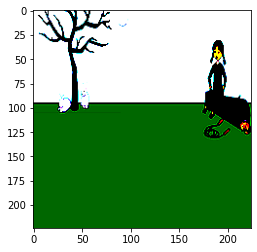

In [ ]:
from collections import Counter
responses = Counter()

plt.imshow(displayable_img)
print(' '.join(qst_vocab.idx2word(i) for i in question[0]))
for i in range(100):
  output = model(image,question)
  _, pred_exp1 = torch.max(output, 1)  # [batch_size]
  responses[' '.join(ans_vocab.idx2word(i) for i in pred_exp1)]+=1

responses = [(k,responses[k]) for k in responses]
sorted_responses = sorted(responses, key=lambda x: x[1])
x = [_ for _ in range(len(responses))]
labels, y = zip(*sorted_responses)

<BarContainer object of 2 artists>

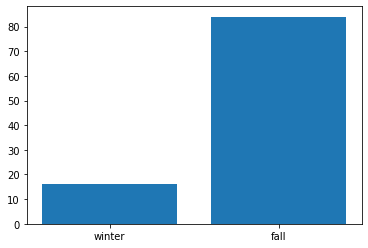

In [ ]:
plt.bar(x, y, tick_label=labels)